# Parallel execution tree expansion with the simulator API

Questo notebook mostra come usare le API REST del simulatore per generare un execution tree in parallelo. L'obiettivo è mantenere l'albero condiviso tra i thread, delegando la creazione dei nodi al simulatore e rispettando il vincolo che ogni thread che genera figli con una natura attiva continui immediatamente l'espansione di quella sottostruttura.


In [1]:
import json
import sys
sys.path.append('simulator/src')
sys.path.append('src')
import os
import threading
import queue
import copy
from typing import Any, Dict, Iterable, List, Optional, Tuple
import requests
import graphviz
import requests
from IPython.display import display
from src.utils.env import IMPACTS_NAMES
from dot import wrapper_execution_tree_to_dot, get_path_to_current_node


URL = "127.0.0.1"
SIMULATOR_PORT = 8001
SOLVER_PORT = 8000

SIMULATOR_SERVER = os.getenv("SIMULATOR_SERVER", "http://127.0.0.1:8001/")
HEADERS = {"Content-Type": "application/json"}

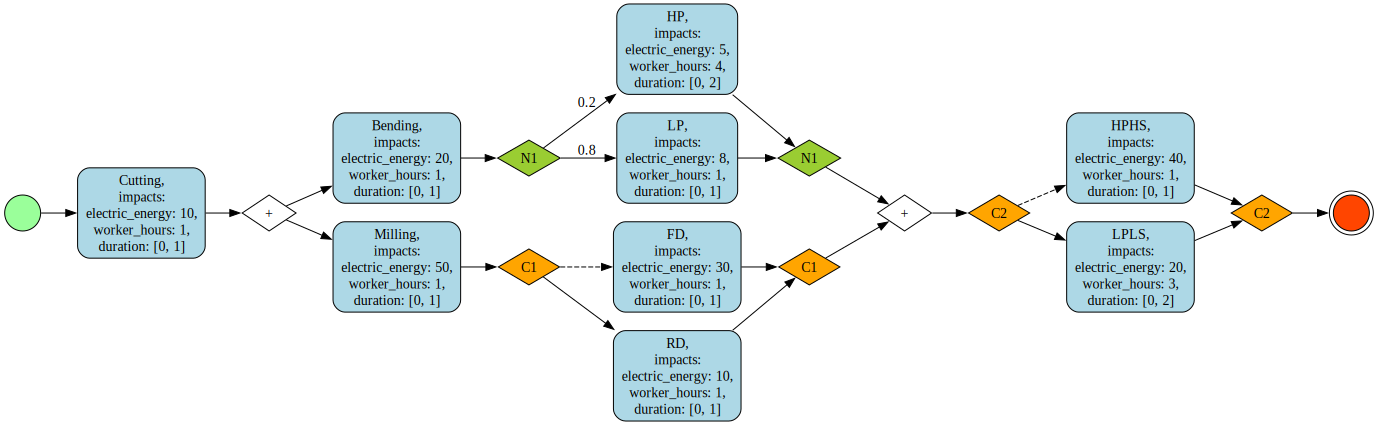

In [2]:
from IPython.core.display import SVG

with open("bpmn_fig8_bound_135_15.json", "r") as f:
    bpmn_file = f.read()

bpmn = json.loads(bpmn_file)

try:
    resp = requests.get(f"http://{URL}:{SOLVER_PORT}/create_bpmn", json={'bpmn': bpmn},  headers=HEADERS)
    resp.raise_for_status()
    display(SVG(graphviz.Source(resp.json()['bpmn_dot']).pipe(format="svg")))

    resp = requests.get(f"http://{URL}:{SOLVER_PORT}/create_parse_tree", json={'bpmn': bpmn},  headers=HEADERS)
    resp.raise_for_status()
    parse_tree = resp.json()['parse_tree']

except requests.exceptions.HTTPError as e:
    print(f"HTTP Error ({resp.status_code}):", resp.json())

In [3]:
bpmn

{'expression': '(Cutting, ((Bending, (HP^[N1]LP)) || (Milling, (FD/[C1]RD))), (HPHS/[C2]LPLS))',
 'impacts': {'Cutting': [10, 1],
  'Bending': [20, 1],
  'Milling': [50, 1],
  'HP': [5, 4],
  'LP': [8, 1],
  'FD': [30, 1],
  'RD': [10, 1],
  'HPHS': [40, 1],
  'LPLS': [20, 3]},
 'durations': {'Cutting': [0, 1],
  'Bending': [0, 1],
  'Milling': [0, 1],
  'HP': [0, 2],
  'LP': [0, 1],
  'FD': [0, 1],
  'RD': [0, 1],
  'HPHS': [0, 1],
  'LPLS': [0, 2]},
 'impacts_names': ['electric_energy', 'worker_hours'],
 'probabilities': {'N1': 0.2},
 'delays': {'C1': 0, 'C2': 0},
 'loop_probability': {},
 'loop_round': {},
 'h': 0}

In [4]:
if 'normalize_parse_tree' not in globals():
    def normalize_parse_tree(data):
        """Return a copy of the parse tree with normalized node types."""
        if isinstance(data, str):
            tree_data = json.loads(data)
        else:
            tree_data = copy.deepcopy(data)

        def _normalize(node):
            if isinstance(node, dict):
                node_type = node.get('type')
                if isinstance(node_type, str):
                    node['type'] = node_type.capitalize()
                for key in ('sx_child', 'dx_child'):
                    child = node.get(key)
                    if isinstance(child, (dict, list)):
                        _normalize(child)
                transitions = node.get('transitions')
                if isinstance(transitions, dict):
                    for child in transitions.values():
                        if isinstance(child, (dict, list)):
                            _normalize(child)
                children = node.get('children')
                if isinstance(children, list):
                    for child in children:
                        if isinstance(child, (dict, list)):
                            _normalize(child)
            elif isinstance(node, list):
                for item in node:
                    if isinstance(item, (dict, list)):
                        _normalize(item)
            return node

        return _normalize(tree_data)



ValueError: Unsupported node type: sequential

## BPMN


In [10]:
request_json = { "bpmn": parse_tree }

response = requests.post(f"http://{URL}:{SIMULATOR_PORT}/execute", headers=HEADERS, json=request_json)
response_json = response.json()

_bpmn = response_json['bpmn']
petri_net = response_json['petri_net']
petri_net_dot = response_json['petri_net_dot']
execution_tree = response_json['execution_tree']


In [11]:
execution_tree

{'root': {'name': 'Root',
  'id': '0',
  'snapshot': {'marking': {'0': {'token': 1, 'age': 0.0, 'visit_count': 0}},
   'probability': 1.0,
   'impacts': [0.0, 0.0],
   'execution_time': 0.0}},
 'current_node': '0'}

In [12]:

from dot import get_active_region_by_pn, wrap_to_dot
marking = {"21": {"token": 1}, "7": {"token": 1}}

active_region_by_pn = get_active_region_by_pn(petri_net, marking)
dot = wrap_to_dot(bpmn, bpmn[IMPACTS_NAMES], active_region_by_pn)
graph = graphviz.Source(dot, format="svg")

display(graph)

KeyError: 'type'

## Worker

Use endpoint `/execute`. Accetta un payload JSON e restituisce strutture pronte da reinserire nell'albero condiviso.


In [ ]:
class Worker:
    def __init__(self, base_url: str = SIMULATOR_SERVER, session: Optional[requests.Session] = None) -> None:
        self.base_url = base_url.rstrip("/") + "/"
        self.session = session or requests.Session()

    def execute(self, payload: Dict[str, Any]) -> Dict[str, Any]:
        response = self.session.post(self.base_url + "execute", headers=HEADERS, json=payload, timeout=60)
        response.raise_for_status()
        data = response.json()
        if "error" in data:
            raise RuntimeError(f"Worker error: {data['error']}")
        return data

    def bootstrap(self, parse_tree_dict: Dict[str, Any]) -> Dict[str, Any]:
        payload = {"bpmn": parse_tree_dict}
        return self.execute(payload)

    def expand_node(
        self,
        shared_state: Dict[str, Any],
        node_id: int,
        *,
        choices: Optional[Iterable[str]] = None,
    ) -> Dict[str, Any]:
        request_payload = {
            "bpmn": shared_state["bpmn"],
            "petri_net": shared_state["petri_net"],
            "petri_net_dot": shared_state["petri_net_dot"],
            "execution_tree": shared_state["execution_tree"],
            "node_id": node_id,
        }
        if choices is not None:
            request_payload["choices"] = list(choices)
        response = self.execute(request_payload)
        if "node" not in response:
            raise KeyError("Simulator response does not contain the expanded node JSON")
        return response

In [ ]:
class SimulatorClient(Worker):
    """Lightweight client that reuses the Worker implementation."""
    pass


## Utilità per navigare l'albero

Funzioni di supporto per contare i nodi, estrarre percorsi e aggiornare porzioni dell'albero senza blocchi globali.


In [ ]:
def iter_pending_paths(node: Dict[str, Any], path: Tuple[str, ...] = ()) -> Iterable[Tuple[str, ...]]:
    """Restituisce tutti i percorsi verso nodi con scelte o nature pendenti."""
    if node.get("pending_choices") or node.get("pending_natures"):
        yield path
    for key, child in node.get("transitions", {}).items():
        yield from iter_pending_paths(child, path + (key,))


def get_node_at_path(root: Dict[str, Any], path: Tuple[str, ...]) -> Dict[str, Any]:
    """Segue il percorso e restituisce il dizionario del nodo corrispondente."""
    node = root
    for key in path:
        node = node["transitions"][key]
    return node


def set_node_at_path(root: Dict[str, Any], path: Tuple[str, ...], new_node: Dict[str, Any]) -> None:
    """Sostituisce un nodo all'interno dell'albero seguendo il percorso dato."""
    if not path:
        root.clear()
        root.update(new_node)
        return
    parent = get_node_at_path(root, path[:-1])
    parent["transitions"][path[-1]] = new_node


def count_nodes(node: Dict[str, Any]) -> int:
    """Conta ricorsivamente i nodi dell'albero."""
    total = 1
    for child in node.get("transitions", {}).values():
        total += count_nodes(child)
    return total


def clone_with_children(node: Dict[str, Any]) -> Dict[str, Any]:
    """Crea una copia dell'albero usando la chiave 'children' al posto di 'transitions'."""
    if not node:
        return {}

    def _convert(current: Dict[str, Any]) -> Dict[str, Any]:
        cloned = {key: copy.deepcopy(value) for key, value in current.items() if key != "transitions"}
        children = [
            _convert(child)
            for _, child in sorted(current.get("transitions", {}).items(), key=lambda item: str(item[0]))
        ]
        cloned["children"] = children
        return cloned

    return _convert(node)


## Scheduler parallelo

`ParallelExecutionTreeBuilder` coordina i thread e garantisce che i nodi figli con nature attive vengano espansi immediatamente dallo stesso worker. Ogni nodo dell'albero possiede un proprio lock per evitare un collo di bottiglia globale durante l'inserimento dei figli.


In [ ]:
class ParallelExecutionTreeBuilder:
    """Espande un execution tree sfruttando il simulatore in parallelo."""

    def __init__(self, client: SimulatorClient, max_workers: int = 1) -> None:
        if max_workers < 1:
            raise ValueError("max_workers must be >= 1")
        self.client = client
        self.max_workers = max_workers
        self._queue: "queue.Queue[Tuple[str, ...]]" = queue.Queue()
        self._node_locks: Dict[int, threading.Lock] = {}
        self._locks_guard = threading.Lock()
        self._stop_event = threading.Event()

    def _lock_for(self, node_id: int) -> threading.Lock:
        with self._locks_guard:
            lock = self._node_locks.get(node_id)
            if lock is None:
                lock = threading.Lock()
                self._node_locks[node_id] = lock
            return lock

    def _enqueue_initial_frontier(self, tree_root: Dict[str, Any]) -> None:
        for path in iter_pending_paths(tree_root):
            self._queue.put(path)

    def _schedule_children(self, node: Dict[str, Any], path: Tuple[str, ...]) -> None:
        sequential_expansions: List[Tuple[str, ...]] = []
        for key, child in node.get("transitions", {}).items():
            child_path = path + (key,)
            if child.get("pending_choices") or child.get("pending_natures"):
                if child.get("natures"):
                    sequential_expansions.append(child_path)
                else:
                    self._queue.put(child_path)
        for child_path in sequential_expansions:
            self._expand_path(child_path)

    def _expand_path(self, path: Tuple[str, ...]) -> None:
        if self._stop_event.is_set():
            return
        node = get_node_at_path(self._shared_tree["execution_tree"]["root"], path)
        if not (node.get("pending_choices") or node.get("pending_natures")):
            return
        node_id = node["id"]
        lock = self._lock_for(node_id)
        with lock:
            response = self.client.expand_node(self._shared_tree, node_id)
            expanded_node = response["node"]
            set_node_at_path(self._shared_tree["execution_tree"]["root"], path, expanded_node)
            self._shared_tree["execution_tree"] = response.get("execution_tree", self._shared_tree["execution_tree"])
            updated_node = get_node_at_path(self._shared_tree["execution_tree"]["root"], path)
        self._schedule_children(updated_node, path)

    def _worker(self) -> None:
        while not self._stop_event.is_set():
            try:
                path = self._queue.get(timeout=0.1)
            except queue.Empty:
                if self._queue.empty():
                    break
                continue
            try:
                self._expand_path(path)
            finally:
                self._queue.task_done()

    def build(self, parse_tree_dict: Dict[str, Any]) -> Dict[str, Any]:
        bootstrap = self.client.bootstrap(parse_tree_dict)
        self._shared_tree = {
            "bpmn": bootstrap["bpmn"],
            "petri_net": bootstrap["petri_net"],
            "petri_net_dot": bootstrap["petri_net_dot"],
            "execution_tree": bootstrap["execution_tree"],
        }
        self._enqueue_initial_frontier(self._shared_tree["execution_tree"]["root"])
        workers: List[threading.Thread] = []
        for idx in range(self.max_workers):
            t = threading.Thread(target=self._worker, name=f"tree-worker-{idx}", daemon=True)
            t.start()
            workers.append(t)
        self._queue.join()
        self._stop_event.set()
        for t in workers:
            t.join()
        return self._shared_tree



## Esecuzione della costruzione parallela

L'esempio seguente utilizza quattro thread. Alla fine viene mostrato il numero totale di nodi generati.


In [ ]:
parse_tree_dict = normalize_parse_tree(parse_tree)
impacts_names = bpmn.get(IMPACTS_NAMES, [])



In [ ]:
client = SimulatorClient()
builder = ParallelExecutionTreeBuilder(client, max_workers=4)

shared_state = builder.build(parse_tree_dict)
root_node = shared_state["execution_tree"]["root"]
print("Numero totale di nodi generati:", count_nodes(root_node))
execution_tree = shared_state["execution_tree"]
current_node_id = execution_tree.get("current_node")
converted_root = clone_with_children(execution_tree.get("root", {}))
highlight_path = get_path_to_current_node(converted_root, current_node_id) or []
dot_source = wrapper_execution_tree_to_dot(converted_root, impacts_names, highlight_path)
graph = graphviz.Source(dot_source, format="svg")
display(graph)
